In [1]:
from kafka import KafkaConsumer

# Importing Required libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

# Loading Model from pkl file using pickle

In [4]:
import pickle

static_xgb = pickle.load(open('../xgb_model_static_12_11.pkl', 'rb'))

dynamic_xgb = pickle.load(open('../xgb_model_static_12_11.pkl', 'rb'))


In [5]:
# Declare list for accuracy scores
static_xgb_accuracy = []
dynamic_xgb_accuracy = []

static = []
dynamic=[]

In [6]:
Data_columns = ['timestamp','FQDN_count','subdomain_length','upper','lower','numeric','entropy','special','labels','labels_max','labels_average','longest_word','sld','len','subdomain','Target Attack']

In [7]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

count=0  #Initiate Counter
data = pd.DataFrame() # Data Frame
records = []
ind_record = []
window = 0


for m in consumer:
    count+=1
    if count==0 and window == 0:
        print(m.value)
    k = m.value.decode("utf-8")  #decoding the stream bytes 
    
    
    if "timestamp" in k: #To ignore the header in input 
        pass
    else:  
        records.append(k)  #Appending the input records 
        
    if count==1000:   # Counter for 1000 records 
        window+=1 #Updating Window number
        print("Window Number: ",window)
        count=0  #Counter Resets
        
        for i in records:  #Cleaning and preprocesssing Input records
            c = i.replace('"',"")
            c = c.replace("\\n","")
            t = c.split(',')
            ind_record.append(t)
        
        
        data = data.append(ind_record) # Adding 1000 records to data framework
#         print(data)
        ind_record = [] #Reseting list
        records=[]  #Reseting list

#         # data preprocessing
        target = data[15]   #saving target variable
        target = labelencoder.fit_transform(target) #Label encoding target variables
        
        #Transforming Column "longest_word"
        data[11] = data[11].map(lambda x : int(x) if str(x).isdigit() else int(len(str(x))))  
        
        #label encoding Column "sld","timestamp"
        data[12]= labelencoder.fit_transform(data[12].astype('str'))
        data[0]= labelencoder.fit_transform(data[0].astype('str'))
#         print("ds: ",data[1])
        
        data=data.drop(data.columns[[1,3,10,15]],axis=1) #dropping unrequired columns
#         print(data.head(3))
        #Train-test split
        X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.33)
        print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
        
        #Scaling training data 
        scaled_x_train = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns = X_train.columns
        )

        #Scaling testing data 
        scaled_x_test = pd.DataFrame(
            scaler.transform(X_test),
            columns = X_test.columns
        )
        
        #Using Static model on imput test data
        predictions=static_xgb.predict(scaled_x_test)
        r1 = static_xgb.score(scaled_x_test,Y_test)
        static.append(r1)
        
        #Using dynamic model on imput test data
        predictions_dynamic=dynamic_xgb.predict(scaled_x_test)
        r2 = dynamic_xgb.score(scaled_x_test,Y_test)
        dynamic.append(r2)
        
        #accuracy on static model's predictions
        accuracy = accuracy_score(Y_test, predictions)
        static_xgb_accuracy.append(accuracy)
        print("Static model's accuracy",accuracy)
        
        #accuracy on dynamic model's predictions
        RF_accuracy = accuracy_score(Y_test, predictions_dynamic)
        dynamic_xgb_accuracy.append(RF_accuracy)
        
        print("Dynamic Model's accuracy: ",RF_accuracy)
        
        #Checking Accuracy 
        if RF_accuracy <=0.8:
            #retraining dynamic model on dynamic input data
            print('Retraining in window:',window)
            dynamic_xgb.fit(scaled_x_train, Y_train)
            
    
    if window == 260:
        break
            

Window Number:  1
(669, 12) (330, 12) (669,) (330,)
Static model's accuracy 0.509090909090909
Dynamic Model's accuracy:  0.509090909090909
Retraining in window: 1
Window Number:  2
(1339, 12) (660, 12) (1339,) (660,)
Static model's accuracy 0.22424242424242424
Dynamic Model's accuracy:  0.353030303030303
Retraining in window: 2
[21:54:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Window Number:  3
(2009, 12) (990, 12) (2009,) (990,)
Static model's accuracy 0.16161616161616163
Dynamic Model's accuracy:  0.7606060606060606
Retraining in window: 3
Window Number:  4
(2679, 12) (1320, 12) (2679,) (1320,)
Static model's accura

(34839, 12) (17160, 12) (34839,) (17160,)
Static model's accuracy 0.008391608391608392
Dynamic Model's accuracy:  0.948951048951049
Window Number:  53
(35509, 12) (17490, 12) (35509,) (17490,)
Static model's accuracy 0.010005717552887363
Dynamic Model's accuracy:  0.9422527158376215
Window Number:  54
(36179, 12) (17820, 12) (36179,) (17820,)
Static model's accuracy 0.007968574635241301
Dynamic Model's accuracy:  0.9409090909090909
Window Number:  55
(36849, 12) (18150, 12) (36849,) (18150,)
Static model's accuracy 0.008650137741046832
Dynamic Model's accuracy:  0.9343250688705235
Window Number:  56
(37519, 12) (18480, 12) (37519,) (18480,)
Static model's accuracy 0.008279220779220779
Dynamic Model's accuracy:  0.9423701298701299
Window Number:  57
(38189, 12) (18810, 12) (38189,) (18810,)
Static model's accuracy 0.008665603402445508
Dynamic Model's accuracy:  0.9502923976608187
Window Number:  58
(38859, 12) (19140, 12) (38859,) (19140,)
Static model's accuracy 0.008829676071055382
Dy

(71019, 12) (34980, 12) (71019,) (34980,)
Static model's accuracy 0.004488279016580904
Dynamic Model's accuracy:  0.9423670668953688
Window Number:  107
(71689, 12) (35310, 12) (71689,) (35310,)
Static model's accuracy 0.004049844236760125
Dynamic Model's accuracy:  0.9557632398753894
Window Number:  108
(72359, 12) (35640, 12) (72359,) (35640,)
Static model's accuracy 0.003956228956228956
Dynamic Model's accuracy:  0.9528058361391695
Window Number:  109
(73029, 12) (35970, 12) (73029,) (35970,)
Static model's accuracy 0.0045871559633027525
Dynamic Model's accuracy:  0.9395607450653323
Window Number:  110
(73699, 12) (36300, 12) (73699,) (36300,)
Static model's accuracy 0.00393939393939394
Dynamic Model's accuracy:  0.9605785123966942
Window Number:  111
(74369, 12) (36630, 12) (74369,) (36630,)
Static model's accuracy 0.00414960414960415
Dynamic Model's accuracy:  0.9442533442533443
Window Number:  112
(75039, 12) (36960, 12) (75039,) (36960,)
Static model's accuracy 0.004193722943722

(107199, 12) (52800, 12) (107199,) (52800,)
Static model's accuracy 0.003446969696969697
Dynamic Model's accuracy:  0.9481439393939394
Window Number:  161
(107869, 12) (53130, 12) (107869,) (53130,)
Static model's accuracy 0.0027291549030679465
Dynamic Model's accuracy:  0.9348202522115565
Window Number:  162
(108539, 12) (53460, 12) (108539,) (53460,)
Static model's accuracy 0.0024691358024691358
Dynamic Model's accuracy:  0.9340254395809952
Window Number:  163
(109209, 12) (53790, 12) (109209,) (53790,)
Static model's accuracy 0.0030303030303030303
Dynamic Model's accuracy:  0.9404350250976018
Window Number:  164
(109879, 12) (54120, 12) (109879,) (54120,)
Static model's accuracy 0.0026053215077605323
Dynamic Model's accuracy:  0.9455284552845529
Window Number:  165
(110549, 12) (54450, 12) (110549,) (54450,)
Static model's accuracy 0.0027731864095500458
Dynamic Model's accuracy:  0.9376308539944903
Window Number:  166
(111219, 12) (54780, 12) (111219,) (54780,)
Static model's accura

(142709, 12) (70290, 12) (142709,) (70290,)
Static model's accuracy 0.0023189642907952765
Dynamic Model's accuracy:  0.9422250675771803
Window Number:  214
(143379, 12) (70620, 12) (143379,) (70620,)
Static model's accuracy 0.0024355706598697255
Dynamic Model's accuracy:  0.9407816482582838
Window Number:  215
(144049, 12) (70950, 12) (144049,) (70950,)
Static model's accuracy 0.002142353770260747
Dynamic Model's accuracy:  0.9436786469344609
Window Number:  216
(144719, 12) (71280, 12) (144719,) (71280,)
Static model's accuracy 0.0022867564534231203
Dynamic Model's accuracy:  0.9361391694725028
Window Number:  217
(145389, 12) (71610, 12) (145389,) (71610,)
Static model's accuracy 0.001787459851975981
Dynamic Model's accuracy:  0.9405529953917051
Window Number:  218
(146059, 12) (71940, 12) (146059,) (71940,)
Static model's accuracy 0.0017236586043925493
Dynamic Model's accuracy:  0.9440366972477064
Window Number:  219
(146729, 12) (72270, 12) (146729,) (72270,)
Static model's accurac

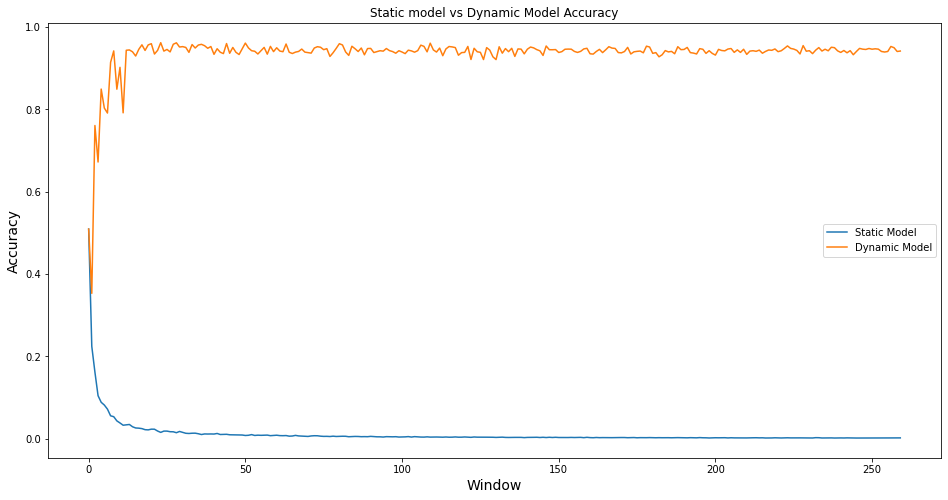

In [8]:
import matplotlib.pyplot as plt
  
# create data
x2 = static_xgb_accuracy
x1 = dynamic_xgb_accuracy
k = [i for i in range(window)]
# plot lines
fig = plt.figure(figsize= (16,8))

plt.plot(k, x2, label = "Static Model")
plt.plot(k, x1, label = "Dynamic Model")
plt.title('Static model vs Dynamic Model Accuracy', fontsize=12)
plt.xlabel('Window', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.show()

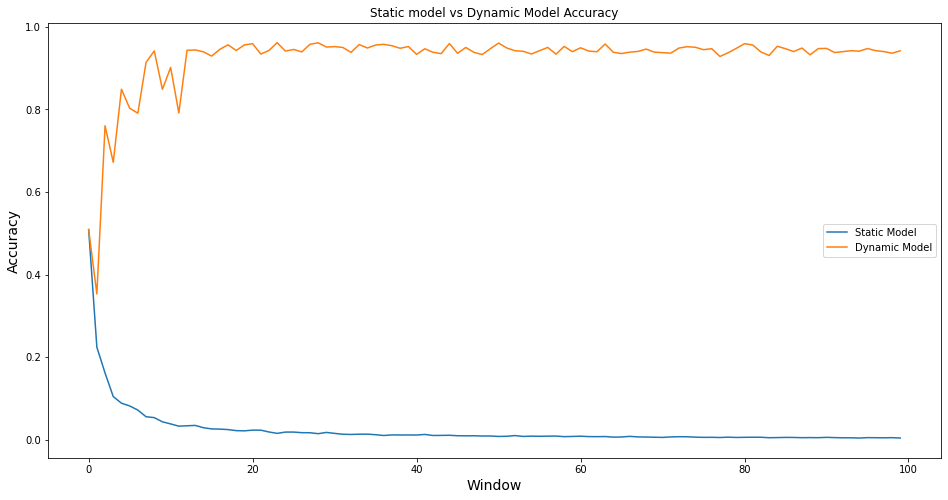

In [9]:
import matplotlib.pyplot as plt
  
# create data
x2 = static_xgb_accuracy
x1 = dynamic_xgb_accuracy
k = [i for i in range(window)]
# plot lines
fig = plt.figure(figsize= (16,8))

plt.plot(k[:100], x2[:100], label = "Static Model")
plt.plot(k[:100], x1[:100], label = "Dynamic Model")
plt.title('Static model vs Dynamic Model Accuracy', fontsize=12)
plt.xlabel('Window', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.show()